In [80]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('Agg')
#matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
%matplotlib inline


In [81]:

volatile_stocks = ['TSLA', 'NVDA', 'AMD', 'BYND', 'PLTR', 'NIO', 'SPCE', 'GME', 'AMC', 'BB']

#past 91 days price data
#1mo flott, 1y, lange
data = yf.download(volatile_stocks, period='5y') #['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
#adjusted close prices
adj_close = data['Adj Close']
cumulative_returns = (adj_close / adj_close.iloc[0]) - 1

[*********************100%***********************]  10 of 10 completed


  Ticker  Daily Volatility  Annualized Volatility
0   TSLA          0.042224               0.670279
1   NVDA          0.034510               0.547822
2    AMD          0.033115               0.525678
3   BYND          0.049016               0.778099
4   PLTR          0.045025               0.714746
5    NIO          0.050762               0.805828
6   SPCE          0.062232               0.987906
7    GME          0.099650               1.581900
8    AMC          0.121530               1.929230
9     BB          0.045121               0.716266
TSLA
 State  Min  Max  Average
     0    1   22     11.5
     1    1    1      1.0
     2    1 1207    411.0
Predicted next 200 days: uuuuddddddddddduuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuudddddddddddddddddddddddndddddddddduunddndddnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn
NVDA
 State  Min  Max  Average
     0    1    8     3.00
     1    1    1     1.00
     2    1 1211   206.83
Predic

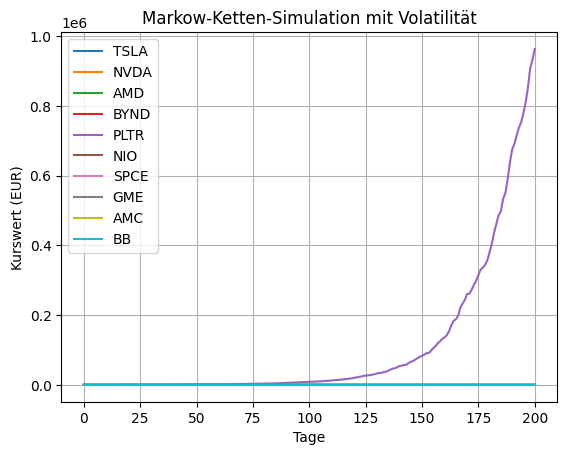

In [16]:
#3 zustände - up & down
#down = 0
#up = 1
#applicable for rows and colums as well - easily extendable for more weather states

def predict_next_day(return_):
    # Select the next state based on the current state and transition probabilities
    return int(np.random.choice([0, 1, 2], p=transition_matrix[return_]))

def predict_next_days(return_, days=200):
    prediction = [return_]  #is not 100% correct term, but for iteration very easy
    for _ in range(days):
        next_day = predict_next_day(prediction[-1])  

        #control consecutive_days
        current_state = prediction[-1]
        counter_current_consecutive_days = 0
        for item in reversed(prediction):
            if item == current_state: counter_current_consecutive_days+=1
            else: break
        #print(counter_current_consecutive_days)

        # Beispielwerte für min, average und max
        min_days = min(consecutive[current_state])
        average_days = average = sum(liste) / len(liste)
        max_days =  max(consecutive[current_state])
        
        # Standardabweichung bestimmen (z. B. ein Drittel des Bereichs zwischen min und max)
        std_dev = (max_days - min_days) / 3
        
        # Zufälligen max_days basierend auf Gaußscher Normalverteilung generieren
        random_max_days = int(np.random.normal(loc=average_days, scale=std_dev))
        
        # Sicherstellen, dass max_days in den Grenzen bleibt
        random_max_days = max(min_days, min(max_days, random_max_days))
        
#            print(f"Zufällige max_days: {random_max_days}")

        if counter_current_consecutive_days > random_max_days:
            #change to other state according to transition matrix
            #print('todo')
            p = np.delete(transition_matrix[return_],current_state) #checkn

            p /= p.sum()  # Sum of each row
            prediction.append(int(np.random.choice([0, 1], p=p)))
            #return prediction[1:]
#                print ('changed from '+str(current_state)+'to'+str(prediction[-1]))
        else: prediction.append(next_day)
    return prediction[1:]  # Return the predicted weather for the upcoming days (excluding weather_current_day)

def calc_volatility():
    volatility_results = []    
    for ticker in volatile_stocks:
        # tägliche Renditen
#        daily_returns = data[ticker].pct_change() 
        daily_returns = data['Adj Close'][ticker].pct_change()

        # daily volatility (Standardabweichung der täglichen Renditen)
        daily_volatility = np.std(daily_returns)
        annual_volatility = daily_volatility * np.sqrt(252) #252 = average working days per year
        volatility_results.append({
            'Ticker': ticker,
            'Daily Volatility': daily_volatility,
            'Annualized Volatility': annual_volatility
        })
    volatility_df = pd.DataFrame(volatility_results)
    return volatility_results, volatility_df

volatility_results, volatility_df = calc_volatility()

print (volatility_df)
for ticker in volatile_stocks:
    print (ticker)
    cumulative_returns_apple = cumulative_returns[ticker]
    # Rückgang = 0, Neutral = 1, Anstieg = 2
    cumulative_returns_apple = [
    0 if return_ < -0.005 else 1 if -0.005 <= return_ <= 0.005 else 2 
    for return_ in cumulative_returns_apple
    ]
    transition_matrix = np.array([[0, 0, 0], #down-down, down-neutral, down-up
                                  [0, 0, 0], #neutral-down, neutral-neutral, neutral-up
                                  [0, 0, 0]]) #up-down, up-neutral, up-up
    
    # Update transition matrix based on weather_month
    for i, return_ in enumerate(cumulative_returns_apple[:-90]):
        if i + 1 == len(cumulative_returns_apple): 
            continue
        transition_matrix[int(return_), int(cumulative_returns_apple[i + 1])] += 1
    
    # Normalize transition matrix row-wise
    #to avoid nan: if 0=>1
    for i, line in enumerate(transition_matrix):
        for j, number in enumerate(line):
            if number == 0:
                transition_matrix[i,j] +=1
    
    transition_matrix = transition_matrix.astype(float)  # Ensure float type for division
    row_sums = transition_matrix.sum(axis=1)  # Sum of each row
    transition_matrix /= row_sums[:, np.newaxis]  # Normalize each row
#    print("Normalized Transition Matrix:\n", transition_matrix)
    #ANALYSE - ANSTIEG; RÜCKGANG; NEUTRAL 
    #CONSECUTIVE DAYS   
    # Variablen initialisieren
    consecutive_days = []
    current_state = cumulative_returns_apple[0]
    count = 1
    
    # Schleife durch die Liste, um Sequenzen zu zählen
    for i in range(1, len(cumulative_returns_apple)):
        if cumulative_returns_apple[i] == current_state:
            # Gleicher Zustand, Zähler erhöhen
            count += 1
        else:
            # Neuer Zustand, Sequenz abschließen
            consecutive_days.append((current_state, count))
            current_state = cumulative_returns_apple[i]
            count = 1
#            print('muesste hier nicht einfach der count in ruhe gelassen werden?') - nein, der alte count wird gespeichert und ich fange neu an zu zählen
    # Letzte Sequenz hinzufügen
    consecutive_days.append((current_state, count))
    
    # Ergebnis anzeigen
    #print("Consecutive Days:")
    #for state, days in consecutive_days:
    #    print(f"State {state}: {days} days")
        
    consecutive = [[],[],[]]
    for state, days in consecutive_days:
        consecutive[state].append(days)
    
#    for i,liste in enumerate( consecutive):
 #       if liste == []: 
  #          liste = [1]
   #         consecutive[i] = [1]
        # Minimum und Maximum
    #    print(f"Min: {min(liste)}")
     #   print(f"Max: {max(liste)}")
        
        # Durchschnitt berechnen
    #    average = sum(liste) / len(liste)
     #   print(f"Average: {average:.2f}")


    # Berechnung der Statistiken für jeden Zustand
    stats = []
    for i, liste in enumerate(consecutive):
        if not liste:
            liste = [1]  # Falls eine Liste leer ist, setzen wir sie auf 1
        
        if days: 
            if min(liste) > days: print ('minimal value of state ',i,'is larger than days to predict.',min(liste),'Reconsider.')
            
        if min(liste) > 200: print ('minimal value of state ',i,'is larger than 200, which is no good for the simulation.','Reconsider.')
        
        stats.append({
            'State': i,
            'Min': min(liste),
            'Max': max(liste),
            'Average': round(sum(liste) / len(liste), 2)
        })
    
    # Umwandlung in DataFrame und Ausgabe als Tabelle
    df_stats = pd.DataFrame(stats)
    
    # Kompakte tabellarische Darstellung im Terminal ausgeben
    print(df_stats.to_string(index=False))




    
    start_value = adj_close.iloc[-1][ticker]  # Letzter Schlusskurs der Aktie als Startwert
    current_value = start_value
    #start_value = adj_close.loc['2023-10-01', ticker]  # Kurs am 1. Oktober 2023
    #current_value = start_value
#    print('Startwert von letztem Börsenschluss - alternativ Datum manuell eingeben')
    # Startdatum für die letzten 3 Monate berechnen
    #start_date = data.index[-1] - timedelta(days=90)
    #data_3_months = data[start_date:]  
    # Startwert für die Simulation
    #start_value = data_3_months.iloc[0]
    
    values = [current_value]    
    text = "Predicted next 200 days: "

    volatility = volatility_df.loc[volatility_df['Ticker'] == ticker, 'Daily Volatility'].iloc[0]
#    print('Volatility:',volatility)

    
    for state in predict_next_days(cumulative_returns_apple[-1]):
        if state == 0: 
            random_return = np.random.normal(-volatility, volatility / 2)
            text+='d'#,' down,'
        elif state == 1: 
            random_return = np.random.normal(0, volatility / 2)
            text+='n'#,' neutral,'
        else: 
            random_return = np.random.normal(volatility, volatility / 2)
            text+='u'#,' up,'

        # Neuen Kurswert berechnen
        current_value *= (1 + random_return)
        values.append(current_value)
    print (text)
    
    # Ergebnisse plotten
    plt.plot(values, label=ticker)

# Diagramm konfigurieren
plt.title("Markow-Ketten-Simulation mit Volatilität")
plt.xlabel("Tage")
plt.ylabel("Kurswert (EUR)")
plt.legend()
plt.grid(True)
plt.show()


        
        







da GME und PLTR ein zu extremes Wachstum der Kurswerte haben, mache ich eine Volatilitätsdämpfung.
Bei PLTR ist ein großes Problem, dass der Kurswert nur hochgeht.

  Ticker  Daily Volatility  Annualized Volatility
0   TSLA          0.042224               0.670279
1   NVDA          0.034510               0.547822
2    AMD          0.033115               0.525678
3   BYND          0.049016               0.778099
4   PLTR          0.045025               0.714746
5    NIO          0.050762               0.805828
6   SPCE          0.062232               0.987906
7    GME          0.099650               1.581900
8    AMC          0.121530               1.929230
9     BB          0.045121               0.716266
TSLA
 State  Min  Max  Average
     0    1   22     11.5
     1    1    1      1.0
     2    1 1207    411.0
Predicted next 200 days: uuuudddddddddddddddddddddddnuunnnnndddddndddddddddddddnuuuuuuuuuuuuunuuuuudddddddddddddddddddddddnuudduuunuundddnuuuuuuuudddnddnuuuunnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn
NVDA
 State  Min  Max  Average
     0    1    8     3.00
     1    1    1     1.00
     2    1 1211   206.83
Predic

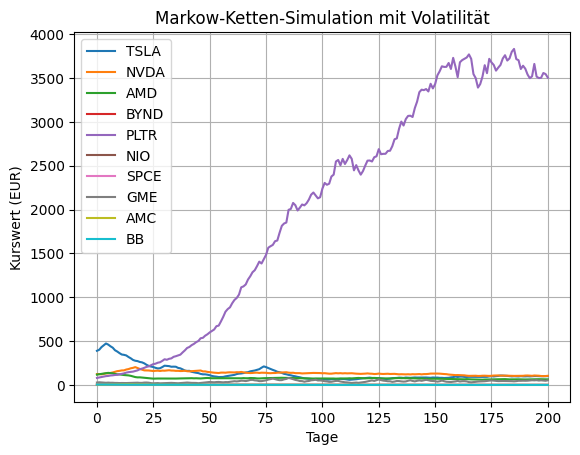

In [15]:
def predict_next_days(return_, days=200):
    prediction = [return_]  #is not 100% correct term, but for iteration very easy
    for _ in range(days):
        next_day = predict_next_day(prediction[-1])  

        #control consecutive_days
        current_state = prediction[-1]
        counter_current_consecutive_days = 0
        for item in reversed(prediction):
            if item == current_state: counter_current_consecutive_days+=1
            else: break
        #print(counter_current_consecutive_days)

        # Beispielwerte für min, average und max
        min_days = min(consecutive[current_state])
        average_days = average = sum(liste) / len(liste)
        max_days =  max(consecutive[current_state])
        
        # Standardabweichung bestimmen (z. B. ein Drittel des Bereichs zwischen min und max)
        std_dev = (max_days - min_days) / 3
        
        # Zufälligen max_days basierend auf Gaußscher Normalverteilung generieren
        random_max_days = int(np.random.normal(loc=average_days, scale=std_dev))
        
        # Sicherstellen, dass max_days in den Grenzen bleibt
        random_max_days = max(min_days, min(max_days, random_max_days))
        
#            print(f"Zufällige max_days: {random_max_days}")

        if counter_current_consecutive_days > random_max_days:
            #change to other state according to transition matrix
            #print('todo')
            p = np.delete(transition_matrix[return_],current_state) #checkn

            p /= p.sum()  # Sum of each row
            prediction.append(int(np.random.choice([0, 1], p=p)))
            #return prediction[1:]
#                print ('changed from '+str(current_state)+'to'+str(prediction[-1]))
        else: prediction.append(next_day)
    return prediction[1:]  # Return the predicted weather for the upcoming days (excluding weather_current_day)



volatility_results, volatility_df = calc_volatility()

print (volatility_df)
for ticker in volatile_stocks:
    print (ticker)
    cumulative_returns_apple = cumulative_returns[ticker]
    # Rückgang = 0, Neutral = 1, Anstieg = 2
    cumulative_returns_apple = [
    0 if return_ < -0.005 else 1 if -0.005 <= return_ <= 0.005 else 2 
    for return_ in cumulative_returns_apple
    ]
    transition_matrix = np.array([[0, 0, 0], #down-down, down-neutral, down-up
                                  [0, 0, 0], #neutral-down, neutral-neutral, neutral-up
                                  [0, 0, 0]]) #up-down, up-neutral, up-up
    
    # Update transition matrix based on weather_month
    for i, return_ in enumerate(cumulative_returns_apple[:-90]):
        if i + 1 == len(cumulative_returns_apple): 
            continue
        transition_matrix[int(return_), int(cumulative_returns_apple[i + 1])] += 1
    
    # Normalize transition matrix row-wise
    #to avoid nan: if 0=>1
    for i, line in enumerate(transition_matrix):
        for j, number in enumerate(line):
            if number == 0:
                transition_matrix[i,j] +=1
    
    transition_matrix = transition_matrix.astype(float)  # Ensure float type for division
    row_sums = transition_matrix.sum(axis=1)  # Sum of each row
    transition_matrix /= row_sums[:, np.newaxis]  # Normalize each row
#    print("Normalized Transition Matrix:\n", transition_matrix)
    #ANALYSE - ANSTIEG; RÜCKGANG; NEUTRAL 
    #CONSECUTIVE DAYS   
    # Variablen initialisieren
    consecutive_days = []
    current_state = cumulative_returns_apple[0]
    count = 1
    
    # Schleife durch die Liste, um Sequenzen zu zählen
    for i in range(1, len(cumulative_returns_apple)):
        if cumulative_returns_apple[i] == current_state:
            # Gleicher Zustand, Zähler erhöhen
            count += 1
        else:
            # Neuer Zustand, Sequenz abschließen
            consecutive_days.append((current_state, count))
            current_state = cumulative_returns_apple[i]
            count = 1
#            print('muesste hier nicht einfach der count in ruhe gelassen werden?') - nein, der alte count wird gespeichert und ich fange neu an zu zählen
    # Letzte Sequenz hinzufügen
    consecutive_days.append((current_state, count))
    
    # Ergebnis anzeigen
    #print("Consecutive Days:")
    #for state, days in consecutive_days:
    #    print(f"State {state}: {days} days")
        
    consecutive = [[],[],[]]
    for state, days in consecutive_days:
        consecutive[state].append(days)
    
#    for i,liste in enumerate( consecutive):
 #       if liste == []: 
  #          liste = [1]
   #         consecutive[i] = [1]
        # Minimum und Maximum
    #    print(f"Min: {min(liste)}")
     #   print(f"Max: {max(liste)}")
        
        # Durchschnitt berechnen
    #    average = sum(liste) / len(liste)
     #   print(f"Average: {average:.2f}")


    # Berechnung der Statistiken für jeden Zustand
    stats = []
    for i, liste in enumerate(consecutive):
        if not liste:
            liste = [1]  # Falls eine Liste leer ist, setzen wir sie auf 1
        
        if days: 
            if min(liste) > days: print ('minimal value of state ',i,'is larger than days to predict.',min(liste),'Reconsider.')
            
        if min(liste) > 200: print ('minimal value of state ',i,'is larger than 200, which is no good for the simulation.','Reconsider.')
        
        stats.append({
            'State': i,
            'Min': min(liste),
            'Max': max(liste),
            'Average': round(sum(liste) / len(liste), 2)
        })
    
    # Umwandlung in DataFrame und Ausgabe als Tabelle
    df_stats = pd.DataFrame(stats)
    
    # Kompakte tabellarische Darstellung im Terminal ausgeben
    print(df_stats.to_string(index=False))




    
    start_value = adj_close.iloc[-1][ticker]  # Letzter Schlusskurs der Aktie als Startwert
    current_value = start_value
    #start_value = adj_close.loc['2023-10-01', ticker]  # Kurs am 1. Oktober 2023
    #current_value = start_value
#    print('Startwert von letztem Börsenschluss - alternativ Datum manuell eingeben')
    # Startdatum für die letzten 3 Monate berechnen
    #start_date = data.index[-1] - timedelta(days=90)
    #data_3_months = data[start_date:]  
    # Startwert für die Simulation
    #start_value = data_3_months.iloc[0]
    
    values = [current_value]    
    text = "Predicted next 200 days: "

    volatility = volatility_df.loc[volatility_df['Ticker'] == ticker, 'Daily Volatility'].iloc[0]
#    print('Volatility:',volatility)

    #mit predict_next_days sage ich kurssteigung oder senkung voraus.
    #mit random return bekomme ich zufällige werte zur kurssteigung.
    #Volatilitätsdämpfung
    
    alpha_damping = 0.001  # Dämpfungsfaktor: Je höher, desto stärker die Begrenzung
    
    
    for state in predict_next_days(cumulative_returns_apple[-1]):
        if state == 0: 
            random_return = np.random.normal(-volatility, volatility / 2)
            text+='d'#,' down,'
        elif state == 1: 
            random_return = np.random.normal(0, volatility / 2)
            text+='n'#,' neutral,'
        else: 
            random_return = np.random.normal(volatility, volatility / 2)
            text+='u'#,' up,'


        
        growth_factor = (1 + random_return) / (1 + alpha_damping * (current_value / start_value))
        # Neuen Kurswert berechnen

        old_current_value = current_value* (1 + random_return)
        current_value *= growth_factor
        percent_change = abs((old_current_value - current_value) / old_current_value)
        
        # Prüfen, ob die Änderung mehr als 1% beträgt
        if percent_change > 0.01:
            print(f"Old Value: {old_current_value:.2f}, New Value: {current_value:.2f}, "
                  f"Change: {percent_change:.2%}, Alpha: {alpha_damping:.2f}, "
                  f"Random Return: {random_return:.4f}, Growth Factor: {growth_factor:.4f}")
        
        values.append(current_value)
    print (text)
    
    # Ergebnisse plotten
    plt.plot(values, label=ticker)

# Diagramm konfigurieren
plt.title("Markow-Ketten-Simulation mit Volatilität")
plt.xlabel("Tage")
plt.ylabel("Kurswert (EUR)")
plt.legend()
plt.grid(True)
plt.show()


        
        







statt des exponenziellen Wachstums von PLTR sieht man hier ein lineares, schließlich gedämpftes Wachstun, aber die anderen Werte werden auch gedämpft, sodass eine andere Lösung für diese konkrete Akzie gesucht werden sollte.

  Ticker  Daily Volatility  Annualized Volatility
0   TSLA          0.042224               0.670279
1   NVDA          0.034510               0.547821
2    AMD          0.033115               0.525678
3   BYND          0.049016               0.778099
4   PLTR          0.045025               0.714746
5    NIO          0.050762               0.805828
6   SPCE          0.062232               0.987906
7    GME          0.099650               1.581900
8    AMC          0.121530               1.929230
9     BB          0.045121               0.716266
TSLA
 State  Min  Max  Average
     0    1   22     11.5
     1    1    1      1.0
     2    1 1207    411.0
Predicted next 200 days: uuuuuuuddddddddddnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn
NVDA
 State  Min  Max  Average
     0    1    8     3.00
     1    1    1     1.00
     2    1 1211   206.83
Predic

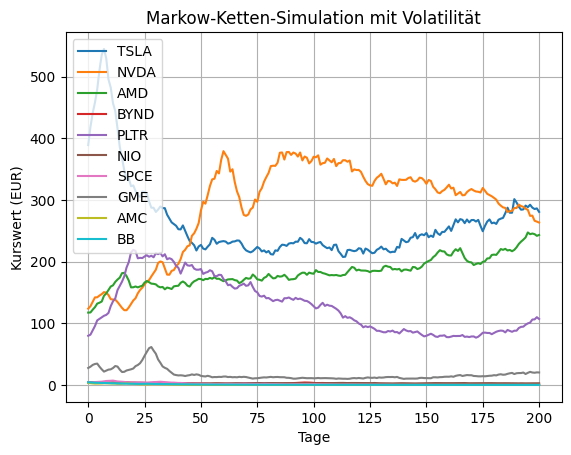

In [26]:
def predict_next_days(return_, statistics, days=200):
    prediction = [return_]  #is not 100% correct term, but for iteration very easy
    for _ in range(days):
        next_day = predict_next_day(prediction[-1])  

        #control consecutive_days
        current_state = prediction[-1]
        counter_current_consecutive_days = 0
        for item in reversed(prediction):
            if item == current_state: counter_current_consecutive_days+=1
            else: break
        #print(counter_current_consecutive_days)

        # Beispielwerte für min, average und max
        min_days = statistics[current_state][0]
        average_days = average = statistics[current_state][2]
        max_days =  statistics[current_state][1]
        
        # Standardabweichung bestimmen (z. B. ein Drittel des Bereichs zwischen min und max)
        std_dev = (max_days - min_days) / 3
        
        # Zufälligen max_days basierend auf Gaußscher Normalverteilung generieren
        random_max_days = int(np.random.normal(loc=average_days, scale=std_dev))
        
        # Sicherstellen, dass max_days in den Grenzen bleibt
        random_max_days = max(min_days, min(max_days, random_max_days))
        
#            print(f"Zufällige max_days: {random_max_days}")
        #print (next_day)
        if counter_current_consecutive_days > 20:
            next_day = 1 # neutral
            prediction.append(next_day)
        elif counter_current_consecutive_days > random_max_days:
            #change to other state according to transition matrix
            #print('todo')
            p = np.delete(transition_matrix[return_],current_state) #checkn

            p /= p.sum()  # Sum of each row
            prediction.append(int(np.random.choice([0, 1], p=p)))
            #return prediction[1:]
#                print ('changed from '+str(current_state)+'to'+str(prediction[-1]))
        else: prediction.append(next_day)
    return prediction[1:]  # Return the predicted weather for the upcoming days (excluding weather_current_day)



volatility_results, volatility_df = calc_volatility()

print (volatility_df)
for ticker in volatile_stocks:
    print (ticker)
    cumulative_returns_apple = cumulative_returns[ticker]
    # Rückgang = 0, Neutral = 1, Anstieg = 2
    cumulative_returns_apple = [
    0 if return_ < -0.005 else 1 if -0.005 <= return_ <= 0.005 else 2 
    for return_ in cumulative_returns_apple
    ]
    transition_matrix = np.array([[0, 0, 0], #down-down, down-neutral, down-up
                                  [0, 0, 0], #neutral-down, neutral-neutral, neutral-up
                                  [0, 0, 0]]) #up-down, up-neutral, up-up
    
    # Update transition matrix based on weather_month
    for i, return_ in enumerate(cumulative_returns_apple[:-90]):
        if i + 1 == len(cumulative_returns_apple): 
            continue
        transition_matrix[int(return_), int(cumulative_returns_apple[i + 1])] += 1
    
    # Normalize transition matrix row-wise
    #to avoid nan: if 0=>1
    for i, line in enumerate(transition_matrix):
        for j, number in enumerate(line):
            if number == 0:
                transition_matrix[i,j] +=1
    
    transition_matrix = transition_matrix.astype(float)  # Ensure float type for division
    row_sums = transition_matrix.sum(axis=1)  # Sum of each row
    transition_matrix /= row_sums[:, np.newaxis]  # Normalize each row
#    print("Normalized Transition Matrix:\n", transition_matrix)
    #ANALYSE - ANSTIEG; RÜCKGANG; NEUTRAL 
    #CONSECUTIVE DAYS   
    # Variablen initialisieren
    consecutive_days = []
    current_state = cumulative_returns_apple[0]
    count = 1
    
    # Schleife durch die Liste, um Sequenzen zu zählen
    for i in range(1, len(cumulative_returns_apple)):
        if cumulative_returns_apple[i] == current_state:
            # Gleicher Zustand, Zähler erhöhen
            count += 1
        else:
            # Neuer Zustand, Sequenz abschließen
            consecutive_days.append((current_state, count))
            current_state = cumulative_returns_apple[i]
            count = 1
#            print('muesste hier nicht einfach der count in ruhe gelassen werden?') - nein, der alte count wird gespeichert und ich fange neu an zu zählen
    # Letzte Sequenz hinzufügen
    consecutive_days.append((current_state, count))
    
    # Ergebnis anzeigen
    #print("Consecutive Days:")
    #for state, days in consecutive_days:
    #    print(f"State {state}: {days} days")
        
    consecutive = [[],[],[]]
    for state, days in consecutive_days:
        consecutive[state].append(days)
    
#    for i,liste in enumerate( consecutive):
 #       if liste == []: 
  #          liste = [1]
   #         consecutive[i] = [1]
        # Minimum und Maximum
    #    print(f"Min: {min(liste)}")
     #   print(f"Max: {max(liste)}")
        
        # Durchschnitt berechnen
    #    average = sum(liste) / len(liste)
     #   print(f"Average: {average:.2f}")


    # Berechnung der Statistiken für jeden Zustand
    stats = []
    statistics = []
    for i, liste in enumerate(consecutive):
        if not liste:
            liste = [1]  # Falls eine Liste leer ist, setzen wir sie auf 1
        
        if days: 
            if min(liste) > days: print ('minimal value of state ',i,'is larger than days to predict.',min(liste),'Reconsider.')
            
        if min(liste) > 200: print ('minimal value of state ',i,'is larger than 200, which is no good for the simulation.','Reconsider.')

        statistics.append([min(liste),max(liste),round(sum(liste) / len(liste), 2)])
        stats.append({
            'State': i,
            'Min': min(liste),
            'Max': max(liste),
            'Average': round(sum(liste) / len(liste), 2)
        })
    
    # Umwandlung in DataFrame und Ausgabe als Tabelle
    df_stats = pd.DataFrame(stats)
    
    # Kompakte tabellarische Darstellung im Terminal ausgeben
    print(df_stats.to_string(index=False))




    
    start_value = adj_close.iloc[-1][ticker]  # Letzter Schlusskurs der Aktie als Startwert
    current_value = start_value
    #start_value = adj_close.loc['2023-10-01', ticker]  # Kurs am 1. Oktober 2023
    #current_value = start_value
#    print('Startwert von letztem Börsenschluss - alternativ Datum manuell eingeben')
    # Startdatum für die letzten 3 Monate berechnen
    #start_date = data.index[-1] - timedelta(days=90)
    #data_3_months = data[start_date:]  
    # Startwert für die Simulation
    #start_value = data_3_months.iloc[0]
    
    values = [current_value]    
    text = "Predicted next 200 days: "

    volatility = volatility_df.loc[volatility_df['Ticker'] == ticker, 'Daily Volatility'].iloc[0]
#    print('Volatility:',volatility)

    #mit predict_next_days sage ich kurssteigung oder senkung voraus.
    #mit random return bekomme ich zufällige werte zur kurssteigung.
    #Volatilitätsdämpfung
    
    alpha_damping = 0.001  # Dämpfungsfaktor: Je höher, desto stärker die Begrenzung
    
    
    for state in predict_next_days(cumulative_returns_apple[-1], statistics):
        if state == 0: 
            random_return = np.random.normal(-volatility, volatility / 2)
            text+='d'#,' down,'
        elif state == 1: 
            random_return = np.random.normal(0, volatility / 2)
            text+='n'#,' neutral,'
        else: 
            random_return = np.random.normal(volatility, volatility / 2)
            text+='u'#,' up,'


        
        growth_factor = (1 + random_return) / (1 + alpha_damping * (current_value / start_value))
        # Neuen Kurswert berechnen

        old_current_value = current_value* (1 + random_return)
        current_value *= growth_factor
        percent_change = abs((old_current_value - current_value) / old_current_value)
        
        # Prüfen, ob die Änderung mehr als 1% beträgt
        if percent_change > 0.01:
            print(f"Old Value: {old_current_value:.2f}, New Value: {current_value:.2f}, "
                  f"Change: {percent_change:.2%}, Alpha: {alpha_damping:.2f}, "
                  f"Random Return: {random_return:.4f}, Growth Factor: {growth_factor:.4f}")
        
        values.append(current_value)
    print (text)
    
    # Ergebnisse plotten
    plt.plot(values, label=ticker)

# Diagramm konfigurieren
plt.title("Markow-Ketten-Simulation mit Volatilität")
plt.xlabel("Tage")
plt.ylabel("Kurswert (EUR)")
plt.legend()
plt.grid(True)
plt.show()


        
        







ich habe keine starken Kursschwankungen mehr und räume jetzt den code auf.

TSLA
NVDA
AMD
BYND
PLTR
minimal value of state  2 is larger than 200, which is no good for the simulation. 1257 Reconsider.
Old Value: 883.00, New Value: 873.87, Change: 1.03%, Alpha: 0.00, Random Return: 0.0600, Growth Factor: 1.0490
Old Value: 876.62, New Value: 867.12, Change: 1.08%, Alpha: 0.00, Random Return: 0.0031, Growth Factor: 0.9923
Old Value: 878.63, New Value: 869.18, Change: 1.08%, Alpha: 0.00, Random Return: 0.0133, Growth Factor: 1.0024
Old Value: 914.85, New Value: 904.99, Change: 1.08%, Alpha: 0.00, Random Return: 0.0525, Growth Factor: 1.0412
Old Value: 935.27, New Value: 924.78, Change: 1.12%, Alpha: 0.00, Random Return: 0.0335, Growth Factor: 1.0219
Old Value: 971.96, New Value: 960.82, Change: 1.15%, Alpha: 0.00, Random Return: 0.0510, Growth Factor: 1.0390
Old Value: 1029.43, New Value: 1017.18, Change: 1.19%, Alpha: 0.00, Random Return: 0.0714, Growth Factor: 1.0587
Old Value: 1081.86, New Value: 1068.24, Change: 1.26%, Alpha: 0.00, Random Return: 0.0636, Growth

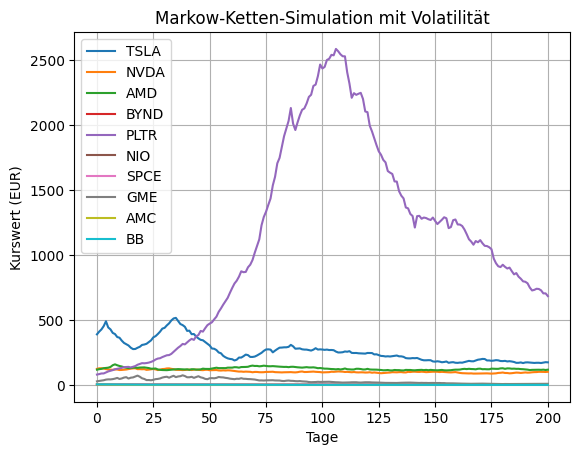

In [30]:
def predict_next_days(return_, statistics, days=200):
    prediction = [return_]  #is not 100% correct term, but for iteration very easy
    for _ in range(days):
        next_day = predict_next_day(prediction[-1])  

        #control consecutive_days
        current_state = prediction[-1]
        counter_current_consecutive_days = 0
        for item in reversed(prediction):
            if item == current_state: counter_current_consecutive_days+=1
            else: break
        min_days = statistics[current_state][0]
        average_days = average = statistics[current_state][2]
        max_days =  statistics[current_state][1]
        
        # Standardabweichung bestimmen (z. B. ein Drittel des Bereichs zwischen min und max)
        std_dev = (max_days - min_days) / 3
        
        # Zufälligen max_days basierend auf Gaußscher Normalverteilung generieren
        random_max_days = int(np.random.normal(loc=average_days, scale=std_dev))
        
        # Sicherstellen, dass max_days in den Grenzen bleibt
        random_max_days = max(min_days, min(max_days, random_max_days))
        
        if counter_current_consecutive_days > 20:
            next_day = 1 # neutral
            prediction.append(next_day)
        elif counter_current_consecutive_days > random_max_days:
            #change to other state according to transition matrix
            p = np.delete(transition_matrix[return_],current_state) #checkn

            p /= p.sum()  # Sum of each row
            prediction.append(int(np.random.choice([0, 1], p=p)))
#                print ('changed from '+str(current_state)+'to'+str(prediction[-1]))
        else: prediction.append(next_day)
    return prediction[1:]  # Return the predicted weather for the upcoming days (excluding weather_current_day)

volatility_results, volatility_df = calc_volatility()

for ticker in volatile_stocks:
    print (ticker)
    cumulative_returns_apple = cumulative_returns[ticker]
    # Rückgang = 0, Neutral = 1, Anstieg = 2
    cumulative_returns_apple = [
    0 if return_ < -0.005 else 1 if -0.005 <= return_ <= 0.005 else 2 
    for return_ in cumulative_returns_apple
    ]
    transition_matrix = np.array([[0, 0, 0], #down-down, down-neutral, down-up
                                  [0, 0, 0], #neutral-down, neutral-neutral, neutral-up
                                  [0, 0, 0]]) #up-down, up-neutral, up-up
    
    # Update transition matrix
    for i, return_ in enumerate(cumulative_returns_apple[:-90]):
        if i + 1 == len(cumulative_returns_apple): 
            continue
        transition_matrix[int(return_), int(cumulative_returns_apple[i + 1])] += 1
    
    # Normalize transition matrix row-wise
    #to avoid nan: if 0=>1
    for i, line in enumerate(transition_matrix):
        for j, number in enumerate(line):
            if number == 0:
                transition_matrix[i,j] +=1
    
    transition_matrix = transition_matrix.astype(float)  # Ensure float type for division
    row_sums = transition_matrix.sum(axis=1)  # Sum of each row
    transition_matrix /= row_sums[:, np.newaxis]  # Normalize each row

    consecutive_days = []
    current_state = cumulative_returns_apple[0]
    count = 1
    
    # Schleife durch die Liste, um Sequenzen zu zählen
    for i in range(1, len(cumulative_returns_apple)):
        if cumulative_returns_apple[i] == current_state:
            # Gleicher Zustand, Zähler erhöhen
            count += 1
        else:
            # Neuer Zustand, Sequenz abschließen
            consecutive_days.append((current_state, count))
            current_state = cumulative_returns_apple[i]
            count = 1
    # Letzte Sequenz hinzufügen
    consecutive_days.append((current_state, count))
            
    consecutive = [[],[],[]]
    for state, days in consecutive_days:
        consecutive[state].append(days)
    
    # Berechnung der Statistiken für jeden Zustand
    stats = []
    statistics = []
    for i, liste in enumerate(consecutive):
        if not liste:
            liste = [1]  # Falls eine Liste leer ist, setzen wir sie auf 1    
        if days: 
            if min(liste) > days: print ('minimal value of state ',i,'is larger than days to predict.',min(liste),'Reconsider.')
        if min(liste) > 200: print ('minimal value of state ',i,'is larger than 200, which is no good for the simulation.',min(liste),'Reconsider.')

        statistics.append([min(liste),max(liste),round(sum(liste) / len(liste), 2)])
        stats.append({
            'State': i,
            'Min': statistics[i][0],
            'Max': statistics[i][1],
            'Average': statistics[i][2]
        })
    
    # Umwandlung in DataFrame und Ausgabe als Tabelle
    df_stats = pd.DataFrame(stats)
    
    # Kompakte tabellarische Darstellung im Terminal ausgeben
#    print(df_stats.to_string(index=False))
    
    start_value = adj_close.iloc[-1][ticker]  # Letzter Schlusskurs der Aktie als Startwert
    current_value = start_value
    #start_value = adj_close.loc['2023-10-01', ticker]  # Kurs am 1. Oktober 2023
#    print('Startwert von letztem Börsenschluss - alternativ Datum manuell eingeben')
    # Startdatum für die letzten 3 Monate berechnen
    #start_date = data.index[-1] - timedelta(days=90)
    #data_3_months = data[start_date:]  
    # Startwert für die Simulation
    #start_value = data_3_months.iloc[0]
    
    values = [current_value]    
    text = "Predicted next 200 days: "

    volatility = volatility_df.loc[volatility_df['Ticker'] == ticker, 'Daily Volatility'].iloc[0]
    #mit predict_next_days sage ich kurssteigung oder senkung voraus.
    #mit random return bekomme ich zufällige werte zur kurssteigung.
    #Volatilitätsdämpfung    
    alpha_damping = 0.001  # Dämpfungsfaktor: Je höher, desto stärker die Begrenzung
    
    for state in predict_next_days(cumulative_returns_apple[-1], statistics):
        if state == 0: 
            random_return = np.random.normal(-volatility, volatility / 2)
            text+='d'#,' down,'
        elif state == 1: 
            random_return = np.random.normal(0, volatility / 2)
            text+='n'#,' neutral,'
        else: 
            random_return = np.random.normal(volatility, volatility / 2)
            text+='u'#,' up,'
        
        growth_factor = (1 + random_return) / (1 + alpha_damping * (current_value / start_value))
        # Neuen Kurswert berechnen

        old_current_value = current_value* (1 + random_return)
        current_value *= growth_factor
        percent_change = abs((old_current_value - current_value) / old_current_value)
        
        # Prüfen, ob die Änderung mehr als 1% beträgt
        if percent_change > 0.01:
            print(f"Old Value: {old_current_value:.2f}, New Value: {current_value:.2f}, "
                  f"Change: {percent_change:.2%}, Alpha: {alpha_damping:.2f}, "
                  f"Random Return: {random_return:.4f}, Growth Factor: {growth_factor:.4f}")
        
        values.append(current_value)
#    print (text)
    
    # Ergebnisse plotten
    plt.plot(values, label=ticker)

# Diagramm konfigurieren
plt.title("Markow-Ketten-Simulation mit Volatilität")
plt.xlabel("Tage")
plt.ylabel("Kurswert (EUR)")
plt.legend()
plt.grid(True)
plt.show()

bei der vorhersage von PLTR kann es immernoch zu starken schwankungen kommen. 
Muss verbesserungen suchen und testen.
Als nächste möchte ich für einzelne Akzien folgendes:
Visualisiere Daten bis vor 3 monaten.
bestimme statistik für markowketten bis vor 3 monaten.
mache 10-100 predictions für die letzten 3 monate
bestimme extreme und mittelwert der predictions und füge zu diagramm hinzu.

TSLA
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


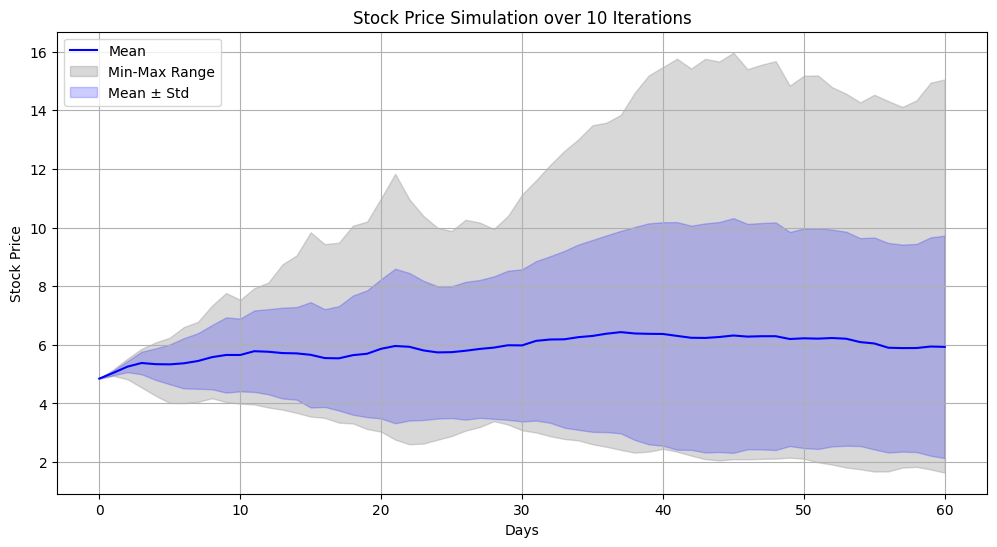

NVDA
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


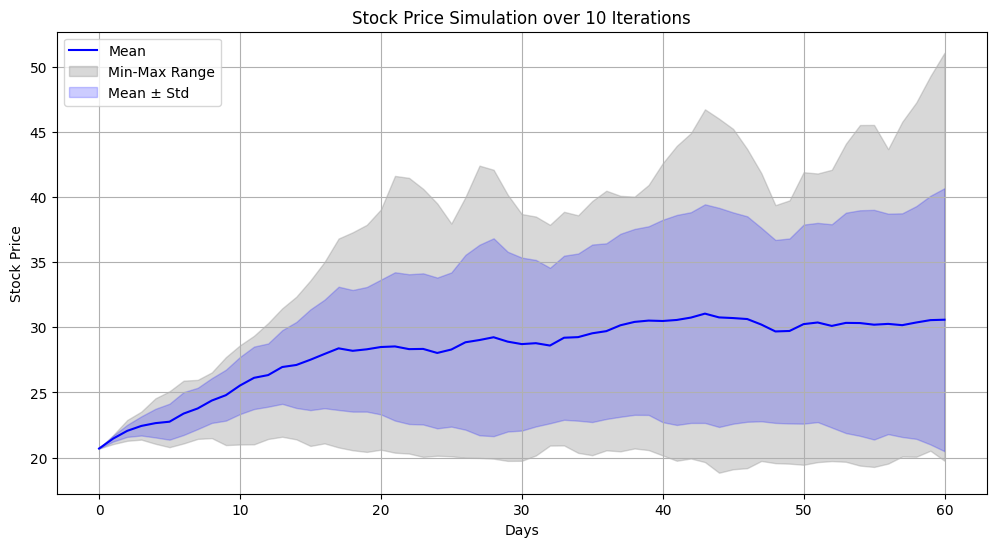

AMD
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


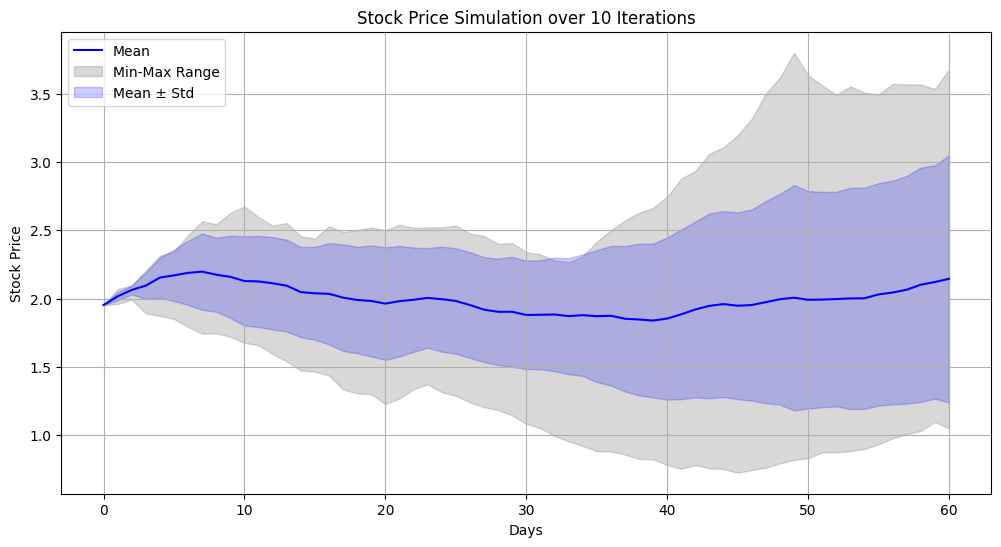

BYND
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


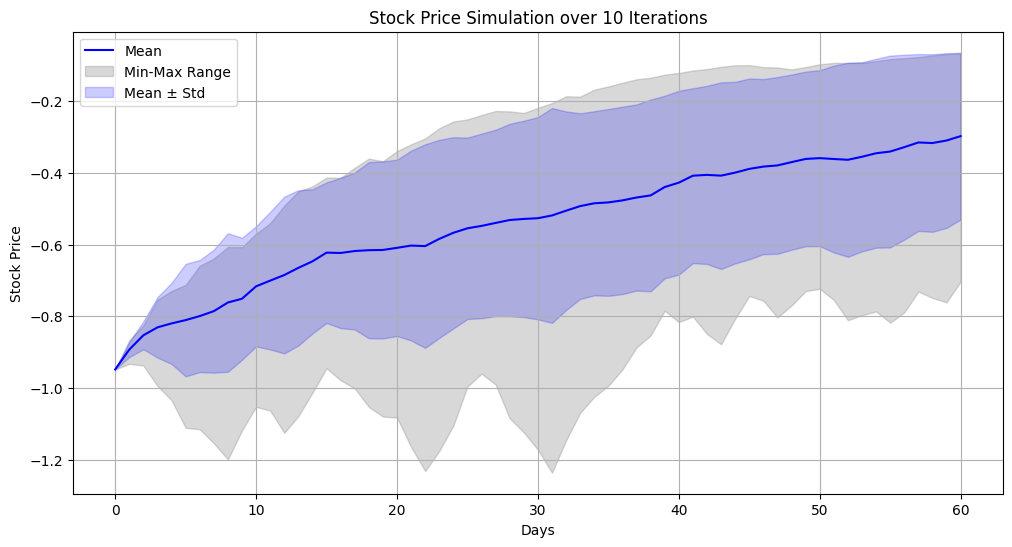

PLTR
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60
minimal value of state  2 is larger than days to predict. 1257 Reconsider.
minimal value of state  2 is larger than 200, which is no good for the simulation. 1257 Reconsider.


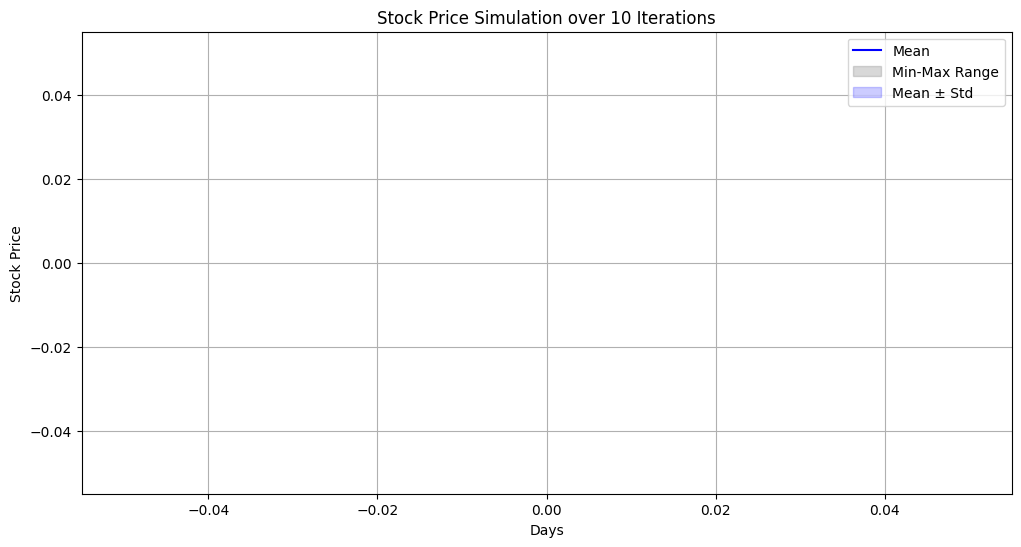

NIO
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


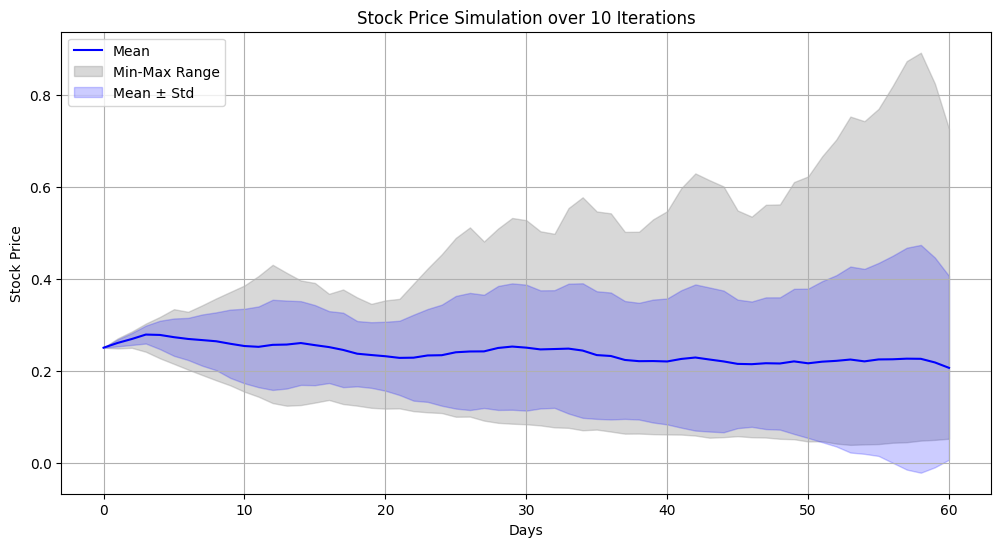

SPCE
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


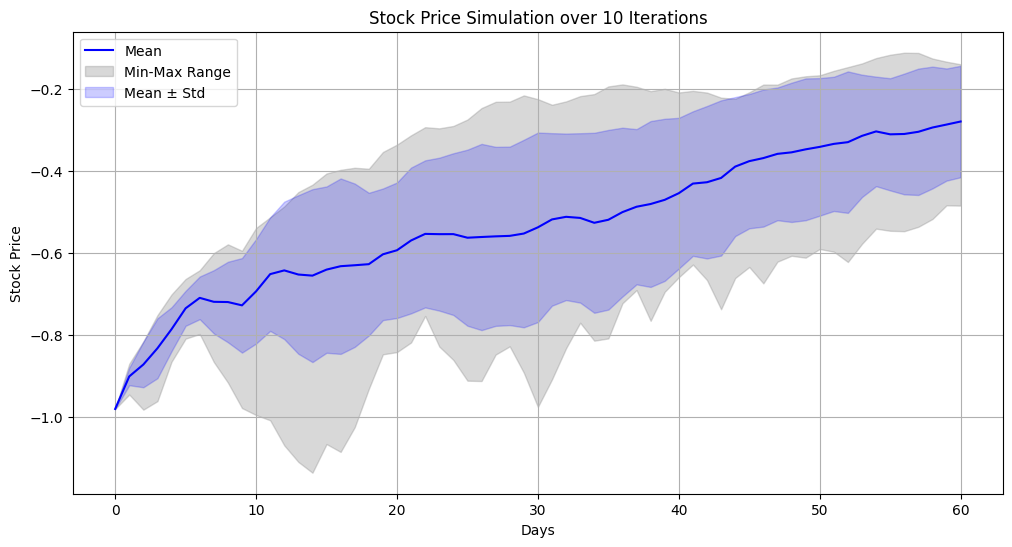

GME
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


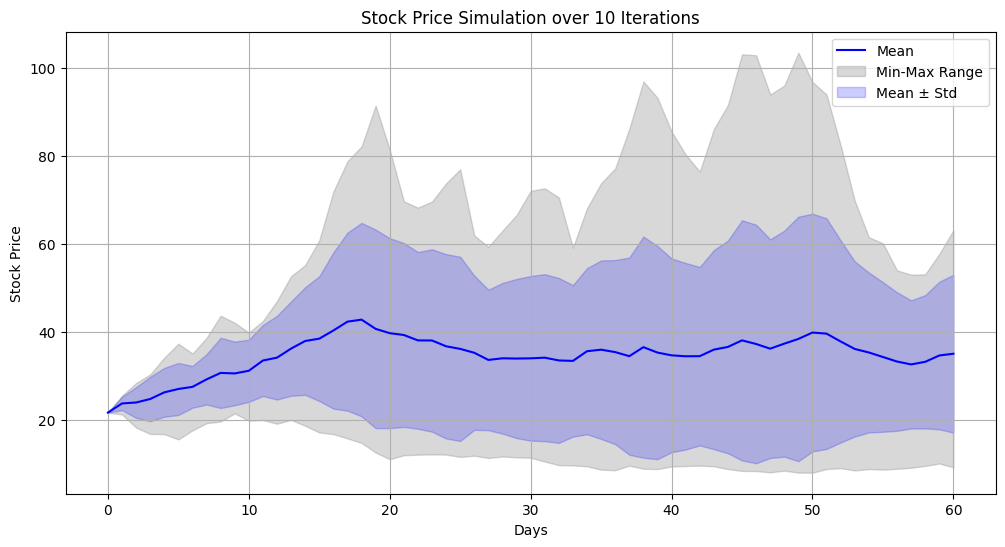

AMC
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


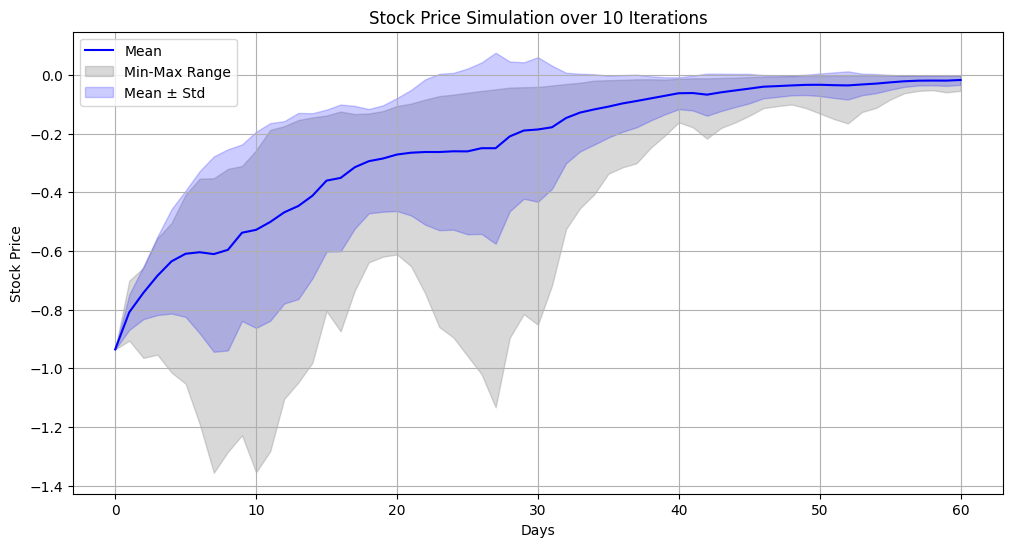

BB
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


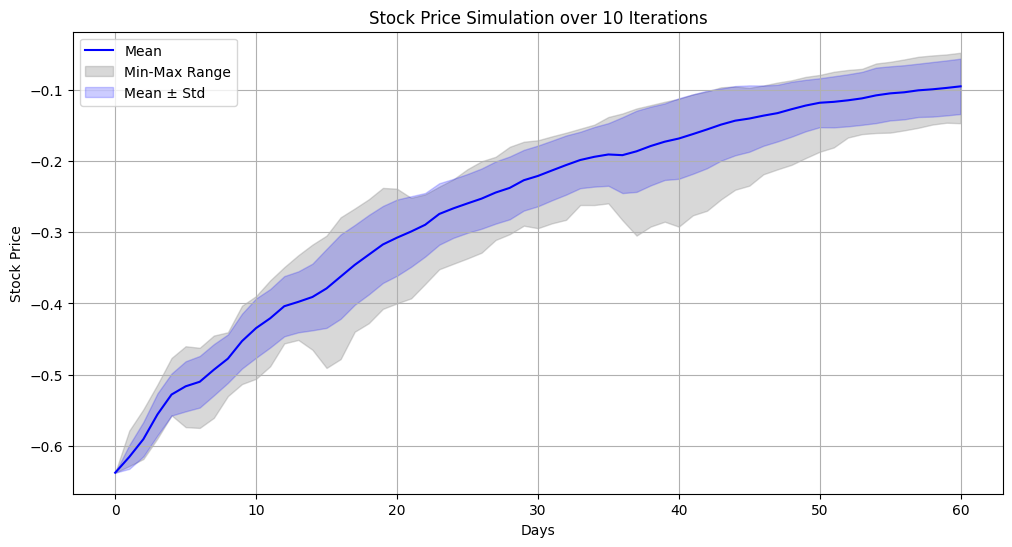

In [84]:
from datetime import timedelta

iterations = 10
#predictions = []

for ticker in volatile_stocks:

    
    print (ticker)
    cumulative_returns_apple = cumulative_returns[ticker]

    # Annahme: cumulative_returns_apple ist ein Pandas Series-Objekt mit Zeitstempeln als Index
    # Letzten Börsentag bestimmen
    last_day = cumulative_returns_apple.index[-1]  # Letzter verfügbarer Börsentag
    
    # Börsentag vor 3 Monaten bestimmen (ca. 90 Tage zurück)
    three_months_ago = last_day - timedelta(days=90)
    start_value = cumulative_returns_apple.loc[three_months_ago]  

    # Sicherstellen, dass wir den nächsten Börsentag im Index finden (da Wochenenden und Feiertage existieren)
    #three_months_ago = cumulative_returns_apple.index[cumulative_returns_apple.index.get_loc(three_months_ago, method="nearest")]

    nearest_idx = cumulative_returns_apple.index.get_indexer([three_months_ago], method="nearest")[0]
    three_months_ago = cumulative_returns_apple.index[nearest_idx]

    
    # Debugging: Prüfen, ob das Datum korrekt bestimmt wurde
    print(f"Letzter Börsentag: {last_day}, Börsentag vor 3 Monaten: {three_months_ago}")
    
    days = len(cumulative_returns_apple.loc[three_months_ago:])
    print(days)
#    print (ente)

    
    # Rückgang = 0, Neutral = 1, Anstieg = 2
    cumulative_returns_apple = [
    0 if return_ < -0.005 else 1 if -0.005 <= return_ <= 0.005 else 2 
    for return_ in cumulative_returns_apple
    ]
    transition_matrix = np.array([[0, 0, 0], #down-down, down-neutral, down-up
                                  [0, 0, 0], #neutral-down, neutral-neutral, neutral-up
                                  [0, 0, 0]]) #up-down, up-neutral, up-up
    
    # Update transition matrix
    for i, return_ in enumerate(cumulative_returns_apple[:-days]):
        if i + 1 == len(cumulative_returns_apple): 
            continue
        transition_matrix[int(return_), int(cumulative_returns_apple[i + 1])] += 1
    
    # Normalize transition matrix row-wise
    #to avoid nan: if 0=>1
    for i, line in enumerate(transition_matrix):
        for j, number in enumerate(line):
            if number == 0:
                transition_matrix[i,j] +=1
    
    transition_matrix = transition_matrix.astype(float)  # Ensure float type for division
    row_sums = transition_matrix.sum(axis=1)  # Sum of each row
    transition_matrix /= row_sums[:, np.newaxis]  # Normalize each row

    consecutive_days = []
    current_state = cumulative_returns_apple[0]
    count = 1
    
    # Schleife durch die Liste, um Sequenzen zu zählen
    for i in range(1, len(cumulative_returns_apple)):
        if cumulative_returns_apple[i] == current_state:
            # Gleicher Zustand, Zähler erhöhen
            count += 1
        else:
            # Neuer Zustand, Sequenz abschließen
            consecutive_days.append((current_state, count))
            current_state = cumulative_returns_apple[i]
            count = 1
    # Letzte Sequenz hinzufügen
    consecutive_days.append((current_state, count))
            
    consecutive = [[],[],[]]
    for state, days_loaded in consecutive_days:
        consecutive[state].append(days_loaded)
    
    # Berechnung der Statistiken für jeden Zustand
    stats = []
    statistics = []
    for i, liste in enumerate(consecutive):
        if not liste:
            liste = [1]  # Falls eine Liste leer ist, setzen wir sie auf 1    
        if days: 
            if min(liste) > days: print ('minimal value of state ',i,'is larger than days to predict.',min(liste),'Reconsider.')
        if min(liste) > 200: print ('minimal value of state ',i,'is larger than 200, which is no good for the simulation.',min(liste),'Reconsider.')

        statistics.append([min(liste),max(liste),round(sum(liste) / len(liste), 2)])
        stats.append({
            'State': i,
            'Min': statistics[i][0],
            'Max': statistics[i][1],
            'Average': statistics[i][2]
        })
    
    # Umwandlung in DataFrame und Ausgabe als Tabelle
    df_stats = pd.DataFrame(stats)
    
    # Kompakte tabellarische Darstellung im Terminal ausgeben
#    print(df_stats.to_string(index=False))
    
#    start_value = adj_close.iloc[-1][ticker]  # Letzter Schlusskurs der Aktie als Startwert
 #   current_value = start_value
    #start_value = adj_close.loc['2023-10-01', ticker]  # Kurs am 1. Oktober 2023
#    print('Startwert von letztem Börsenschluss - alternativ Datum manuell eingeben')
    # Startdatum für die letzten 3 Monate berechnen
    #start_date = data.index[-1] - timedelta(days=90)
    #data_3_months = data[start_date:]  
    # Startwert für die Simulation
    #start_value = data_3_months.iloc[0]
    
    

    volatility = volatility_df.loc[volatility_df['Ticker'] == ticker, 'Daily Volatility'].iloc[0]
    #mit predict_next_days sage ich kurssteigung oder senkung voraus.
    #mit random return bekomme ich zufällige werte zur kurssteigung.
    #Volatilitätsdämpfung    
    alpha_damping = 0.001  # Dämpfungsfaktor: Je höher, desto stärker die Begrenzung


    all_simulations = [] #np.zeros((iterations, days+1))
    
    for iteration in range(iterations):
        text = "Predicted next "+str(days)+" days: "
        values = [start_value]   
        current_value = start_value
 #       print('days:',days)
        for state in predict_next_days(cumulative_returns_apple[-1], statistics, days):
            if state == 0: 
                random_return = np.random.normal(-volatility, volatility / 2)
                text+='d'#,' down,'
            elif state == 1: 
                random_return = np.random.normal(0, volatility / 2)
                text+='n'#,' neutral,'
            else: 
                random_return = np.random.normal(volatility, volatility / 2)
                text+='u'#,' up,'
            
            growth_factor = (1 + random_return) / (1 + alpha_damping * (current_value / start_value))
            # Neuen Kurswert berechnen
    
            old_current_value = current_value* (1 + random_return)
            current_value *= growth_factor
            percent_change = abs((old_current_value - current_value) / old_current_value)
            
            # Prüfen, ob die Änderung mehr als 1% beträgt
           # if percent_change > 0.01:
            #    print(f"Old Value: {old_current_value:.2f}, New Value: {current_value:.2f}, "
             #         f"Change: {percent_change:.2%}, Alpha: {alpha_damping:.2f}, "
              #        f"Random Return: {random_return:.4f}, Growth Factor: {growth_factor:.4f}")
            
            values.append(current_value)
        #print(values)
        all_simulations.append( values) #[1:])
#    print(f"Shape of all_simulations: {all_simulations.shape}")  # (iterations, days)
    #print(len(all_simulations))
    #for i in all_simulations:
     #   print(len(i))
      #  print (i)


    #    print(all_simulations.size)
    # Umwandlung in DataFrame für bessere Analyse
    df_simulations = pd.DataFrame(all_simulations)
    
    # Berechnung von Statistikwerten pro Tag
    df_summary = pd.DataFrame({
        "Min": df_simulations.min(axis=0),
        "Max": df_simulations.max(axis=0),
        "Mean": df_simulations.mean(axis=0),
        "Std": df_simulations.std(axis=0)
    })
    
    # Visualisierung der Simulationsergebnisse
    plt.figure(figsize=(12, 6))
    plt.plot(df_summary["Mean"], label="Mean", color="blue")
    plt.fill_between(df_summary.index, df_summary["Min"], df_summary["Max"], color="gray", alpha=0.3, label="Min-Max Range")
    plt.fill_between(df_summary.index, df_summary["Mean"] - df_summary["Std"], df_summary["Mean"] + df_summary["Std"], color="blue", alpha=0.2, label="Mean ± Std")
    plt.xlabel("Days")
    plt.ylabel("Stock Price")
    plt.title(f"Stock Price Simulation over {iterations} Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()
#    break

TSLA
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


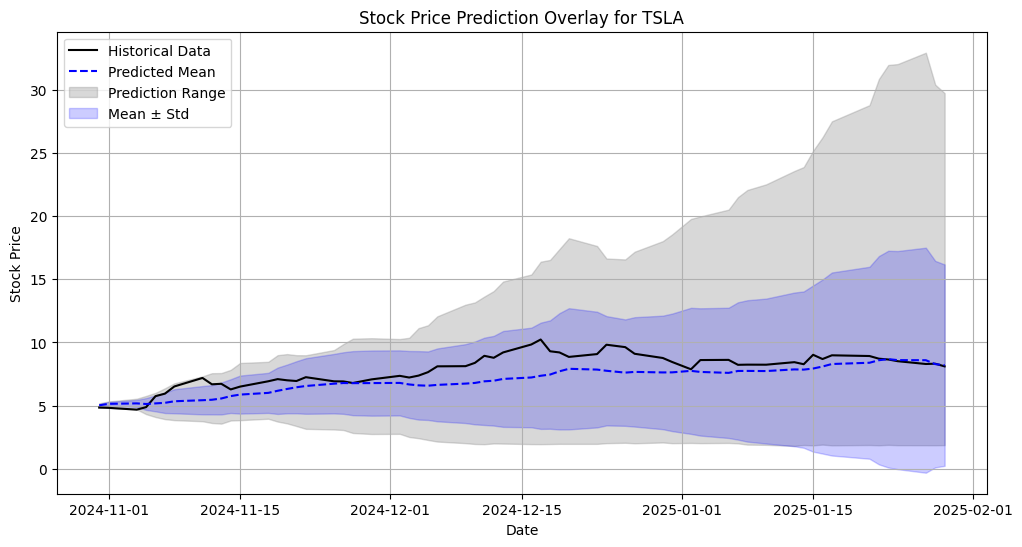

NVDA
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


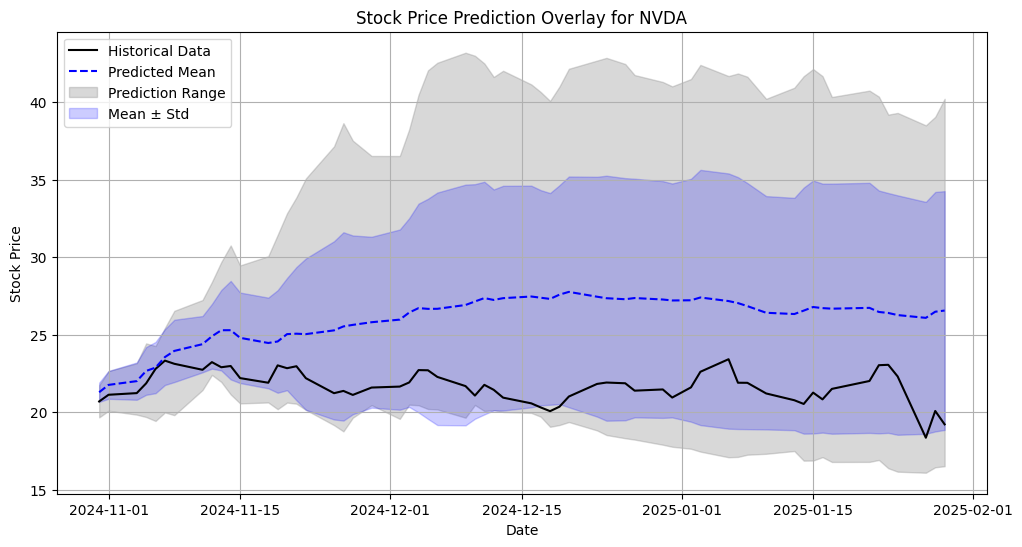

AMD
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


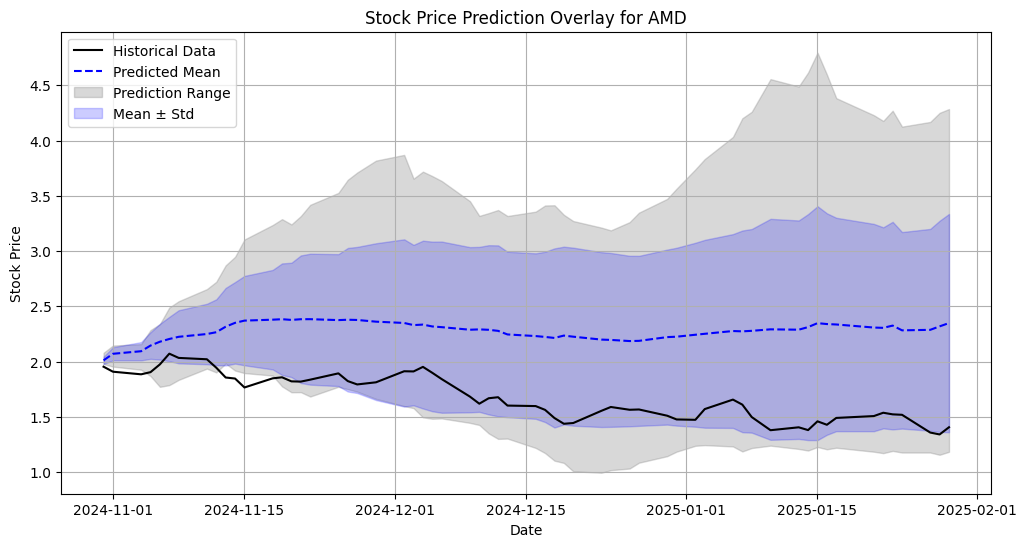

BYND
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


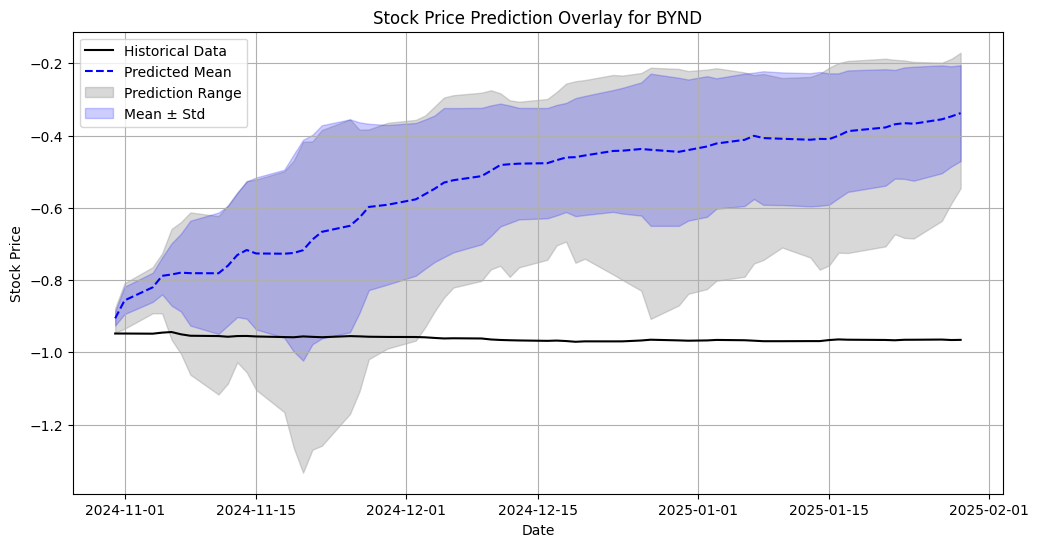

PLTR
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60
minimal value of state  2 is larger than days to predict. 1257 Reconsider.
minimal value of state  2 is larger than 200, which is no good for the simulation. 1257 Reconsider.


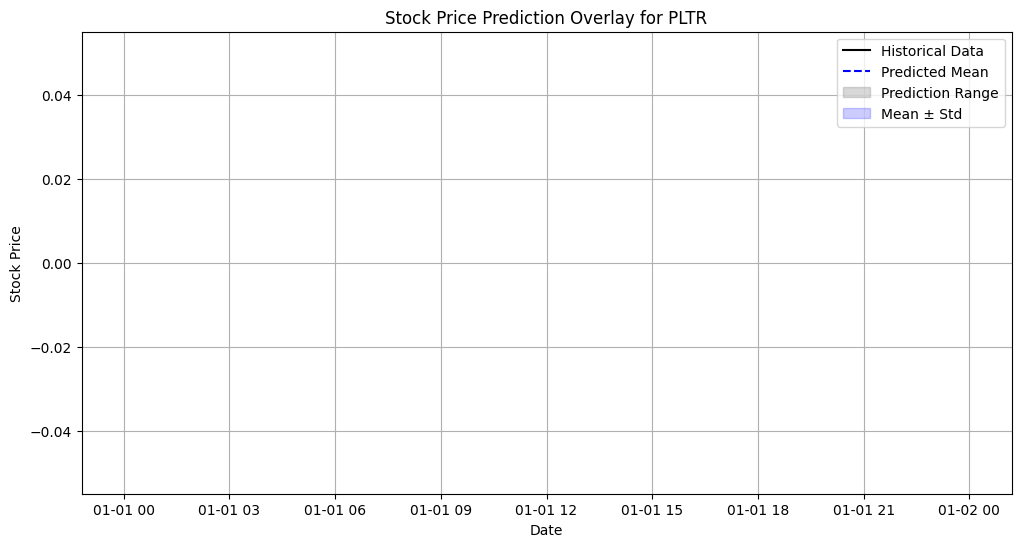

NIO
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


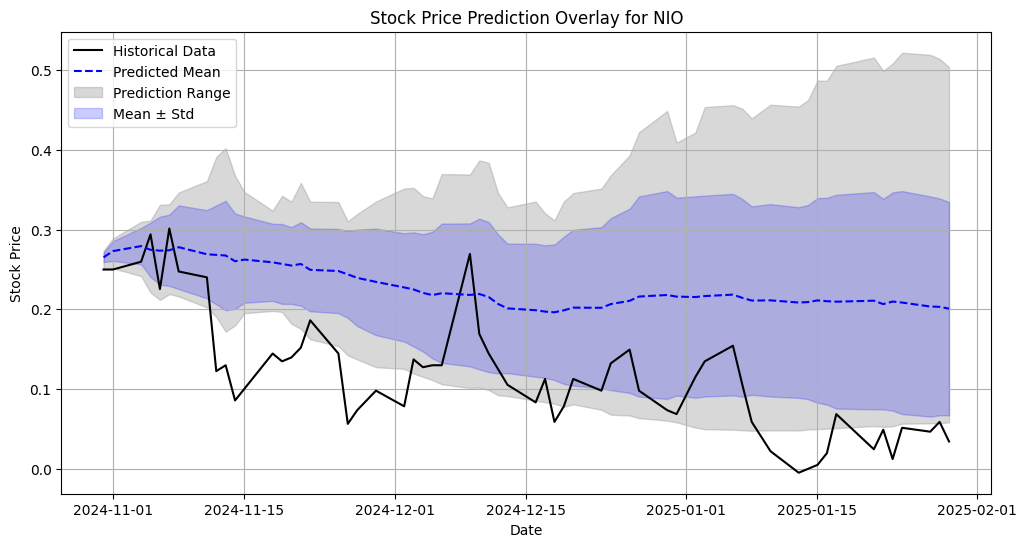

SPCE
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


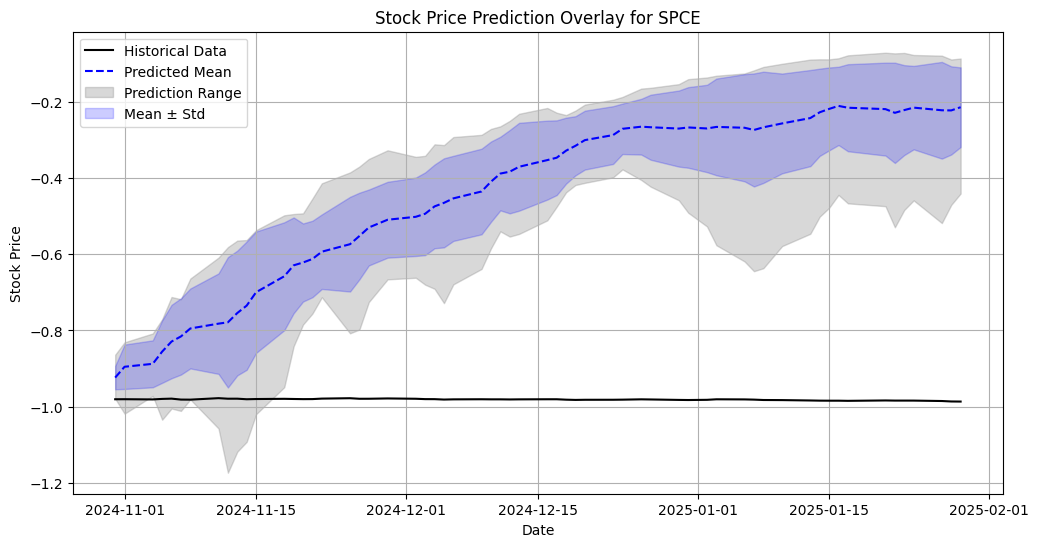

GME
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


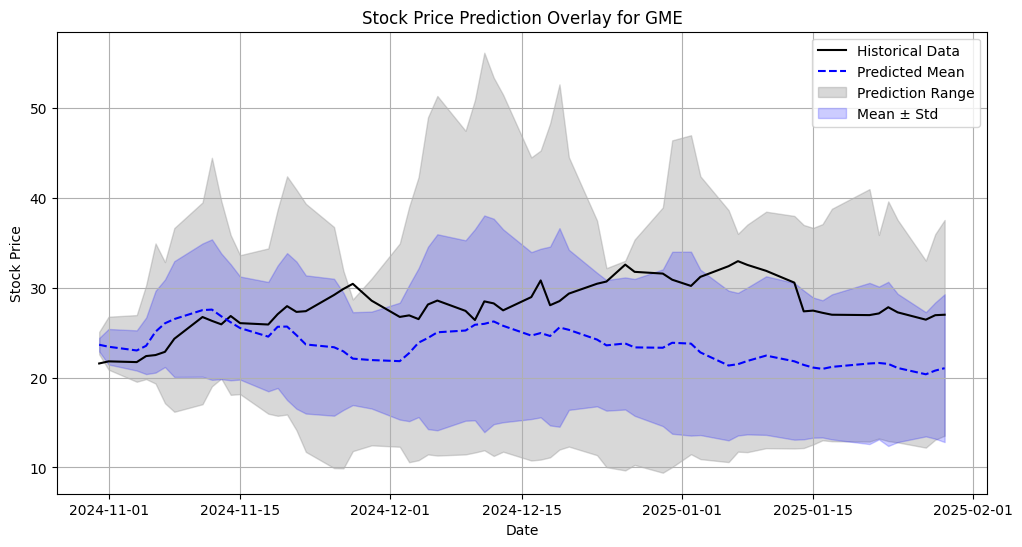

AMC
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


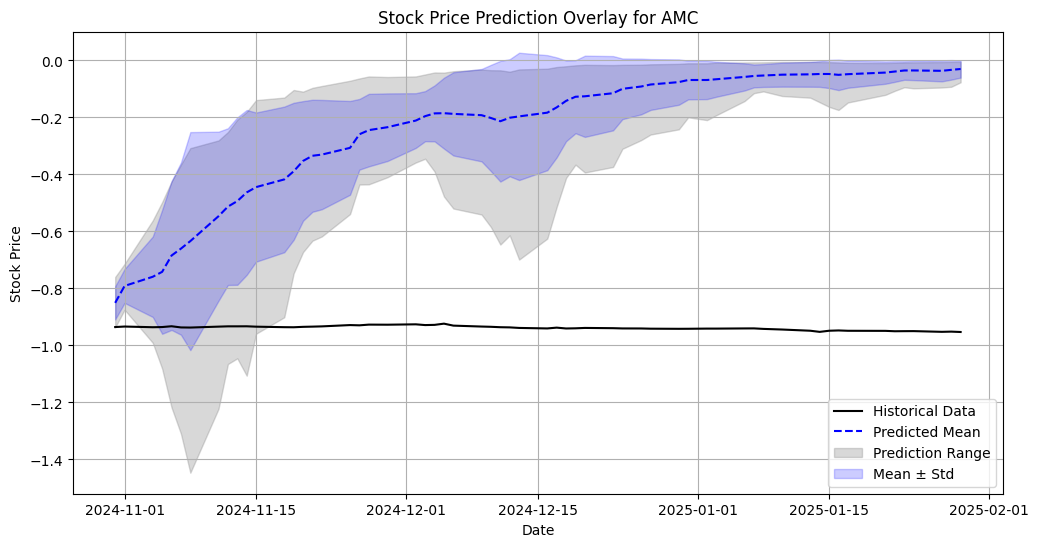

BB
Letzter Börsentag: 2025-01-29 00:00:00+00:00, Börsentag vor 3 Monaten: 2024-10-31 00:00:00+00:00
60


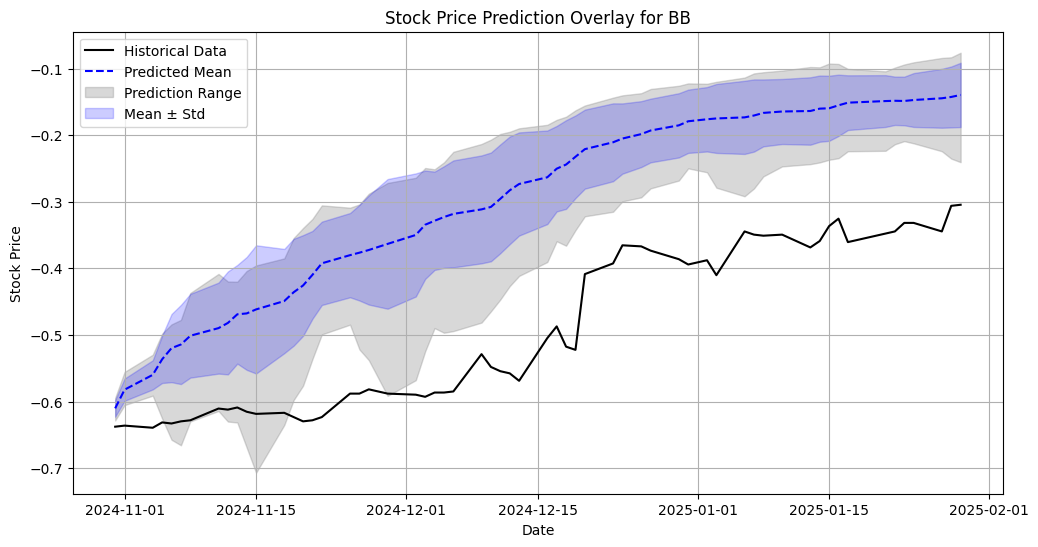

In [88]:
from datetime import timedelta

iterations = 10
#predictions = []

for ticker in volatile_stocks:

    
    print (ticker)
    cumulative_returns_apple = cumulative_returns[ticker]

    # Annahme: cumulative_returns_apple ist ein Pandas Series-Objekt mit Zeitstempeln als Index
    # Letzten Börsentag bestimmen
    last_day = cumulative_returns_apple.index[-1]  # Letzter verfügbarer Börsentag
    
    # Börsentag vor 3 Monaten bestimmen (ca. 90 Tage zurück)
    three_months_ago = last_day - timedelta(days=90)
    start_value = cumulative_returns_apple.loc[three_months_ago]  

    # Sicherstellen, dass wir den nächsten Börsentag im Index finden (da Wochenenden und Feiertage existieren)
    #three_months_ago = cumulative_returns_apple.index[cumulative_returns_apple.index.get_loc(three_months_ago, method="nearest")]

    nearest_idx = cumulative_returns_apple.index.get_indexer([three_months_ago], method="nearest")[0]
    three_months_ago = cumulative_returns_apple.index[nearest_idx]

    
    # Debugging: Prüfen, ob das Datum korrekt bestimmt wurde
    print(f"Letzter Börsentag: {last_day}, Börsentag vor 3 Monaten: {three_months_ago}")
    
    days = len(cumulative_returns_apple.loc[three_months_ago:])
    print(days)
#    print (ente)

    
    # Rückgang = 0, Neutral = 1, Anstieg = 2
    cumulative_returns_apple = [
    0 if return_ < -0.005 else 1 if -0.005 <= return_ <= 0.005 else 2 
    for return_ in cumulative_returns_apple
    ]
    transition_matrix = np.array([[0, 0, 0], #down-down, down-neutral, down-up
                                  [0, 0, 0], #neutral-down, neutral-neutral, neutral-up
                                  [0, 0, 0]]) #up-down, up-neutral, up-up
    
    # Update transition matrix
    for i, return_ in enumerate(cumulative_returns_apple[:-days]):
        if i + 1 == len(cumulative_returns_apple): 
            continue
        transition_matrix[int(return_), int(cumulative_returns_apple[i + 1])] += 1
    
    # Normalize transition matrix row-wise
    #to avoid nan: if 0=>1
    for i, line in enumerate(transition_matrix):
        for j, number in enumerate(line):
            if number == 0:
                transition_matrix[i,j] +=1
    
    transition_matrix = transition_matrix.astype(float)  # Ensure float type for division
    row_sums = transition_matrix.sum(axis=1)  # Sum of each row
    transition_matrix /= row_sums[:, np.newaxis]  # Normalize each row

    consecutive_days = []
    current_state = cumulative_returns_apple[0]
    count = 1
    
    # Schleife durch die Liste, um Sequenzen zu zählen
    for i in range(1, len(cumulative_returns_apple)):
        if cumulative_returns_apple[i] == current_state:
            # Gleicher Zustand, Zähler erhöhen
            count += 1
        else:
            # Neuer Zustand, Sequenz abschließen
            consecutive_days.append((current_state, count))
            current_state = cumulative_returns_apple[i]
            count = 1
    # Letzte Sequenz hinzufügen
    consecutive_days.append((current_state, count))
            
    consecutive = [[],[],[]]
    for state, days_loaded in consecutive_days:
        consecutive[state].append(days_loaded)
    
    # Berechnung der Statistiken für jeden Zustand
    stats = []
    statistics = []
    for i, liste in enumerate(consecutive):
        if not liste:
            liste = [1]  # Falls eine Liste leer ist, setzen wir sie auf 1    
        if days: 
            if min(liste) > days: print ('minimal value of state ',i,'is larger than days to predict.',min(liste),'Reconsider.')
        if min(liste) > 200: print ('minimal value of state ',i,'is larger than 200, which is no good for the simulation.',min(liste),'Reconsider.')

        statistics.append([min(liste),max(liste),round(sum(liste) / len(liste), 2)])
        stats.append({
            'State': i,
            'Min': statistics[i][0],
            'Max': statistics[i][1],
            'Average': statistics[i][2]
        })
    
    # Umwandlung in DataFrame und Ausgabe als Tabelle
    df_stats = pd.DataFrame(stats)
    
    # Kompakte tabellarische Darstellung im Terminal ausgeben
#    print(df_stats.to_string(index=False))
    
#    start_value = adj_close.iloc[-1][ticker]  # Letzter Schlusskurs der Aktie als Startwert
 #   current_value = start_value
    #start_value = adj_close.loc['2023-10-01', ticker]  # Kurs am 1. Oktober 2023
#    print('Startwert von letztem Börsenschluss - alternativ Datum manuell eingeben')
    # Startdatum für die letzten 3 Monate berechnen
    #start_date = data.index[-1] - timedelta(days=90)
    #data_3_months = data[start_date:]  
    # Startwert für die Simulation
    #start_value = data_3_months.iloc[0]
    
    

    volatility = volatility_df.loc[volatility_df['Ticker'] == ticker, 'Daily Volatility'].iloc[0]
    #mit predict_next_days sage ich kurssteigung oder senkung voraus.
    #mit random return bekomme ich zufällige werte zur kurssteigung.
    #Volatilitätsdämpfung    
    alpha_damping = 0.001  # Dämpfungsfaktor: Je höher, desto stärker die Begrenzung
    all_simulations = [] #np.zeros((iterations, days+1))
    
    for iteration in range(iterations):
        text = "Predicted next "+str(days)+" days: "
        values = [start_value]   
        current_value = start_value
 #       print('days:',days)
        for state in predict_next_days(cumulative_returns_apple[-1], statistics, days):
            if state == 0: 
                random_return = np.random.normal(-volatility, volatility / 2)
                text+='d'#,' down,'
            elif state == 1: 
                random_return = np.random.normal(0, volatility / 2)
                text+='n'#,' neutral,'
            else: 
                random_return = np.random.normal(volatility, volatility / 2)
                text+='u'#,' up,'
            
            growth_factor = (1 + random_return) / (1 + alpha_damping * (current_value / start_value))
    
            old_current_value = current_value* (1 + random_return)
            current_value *= growth_factor
            percent_change = abs((old_current_value - current_value) / old_current_value)
            
            values.append(current_value)
        all_simulations.append( values[1:])

        # Umwandlung in DataFrame für bessere Analyse
    df_simulations = pd.DataFrame(all_simulations)
    
    # Berechnung von Statistikwerten pro Tag
    df_summary = pd.DataFrame({
        "Min": df_simulations.min(axis=0),
        "Max": df_simulations.max(axis=0),
        "Mean": df_simulations.mean(axis=0),
        "Std": df_simulations.std(axis=0)
    })
    
    # Visualisierung der Simulationsergebnisse
    
    plt.figure(figsize=(12, 6))
    
    # Prüfen, ob Daten vorhanden sind
    if ticker not in cumulative_returns:
        print(f"Fehlende Daten für {ticker}, überspringe...")
        continue

    # Originale Kursdaten der letzten "days" Tage auswählen
    real_data = cumulative_returns[ticker].iloc[-days:]  # Letzte `days` Tage der echten Daten
    real_dates = real_data.index  # Die echten Daten haben bereits einen Datumsindex

    # Sicherstellen, dass die Vorhersage die gleiche Länge hat
    df_simulations = pd.DataFrame(all_simulations)  # Simulationen als DataFrame
    df_summary = pd.DataFrame({
        "Min": df_simulations.min(axis=0),
        "Max": df_simulations.max(axis=0),
        "Mean": df_simulations.mean(axis=0),
        "Std": df_simulations.std(axis=0)
    })

    # Den Index der Vorhersage anpassen (gleicher Zeitraum wie die echten Daten)
    df_summary.index = real_dates

    # **Plot der echten Daten**
    plt.plot(real_dates, real_data, label="Historical Data", color="black")

    # **Plot der Vorhersage (überlappend)**
    plt.plot(df_summary.index, df_summary["Mean"], label="Predicted Mean", color="blue", linestyle="dashed")
    plt.fill_between(df_summary.index, df_summary["Min"], df_summary["Max"], color="gray", alpha=0.3, label="Prediction Range")
    plt.fill_between(df_summary.index, df_summary["Mean"] - df_summary["Std"], df_summary["Mean"] + df_summary["Std"], color="blue", alpha=0.2, label="Mean ± Std")

    # Diagramm beschriften
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title(f"Stock Price Prediction Overlay for {ticker}")
    plt.legend()
    plt.grid(True)

    # Bild speichern
    plt.savefig(f"prediction_overlay_{ticker}.png")

    # Bild anzeigen
    plt.show()


für folgende Akzien waren die historischen Daten in der Nähe vom Mean: TSLA
für folgende Akzien waren die historischen Daten im Bereich Mean +- Std: NVDA, AMD, GME
für folgende Akzien waren die historischen Daten in der Nähe der Prediction Range: NIO
für folgende Akzien waren die historischen Daten flacher ansteigend als predicted: BB
für folgende Akzien waren die historischen Daten flach, statt ansteigend wie vorhergesagt: BYND, SPCE, AMC
Folgende Simulationen haben nicht geklappt: PLTR

Zusammengefasst haben die simplen Markowsimulationen bei 50% der Stocks passende Vorhersagen produziert.